***Logitic Regression Model***

_____

*Steps:*

1. *Load the cleaned Heart Study Dataset*

2. *Define x and y Variables*

3. *Split the Data into Testing and Training*

4. *Fit the Logit Model*

5. *Predict on the Test Set and Interpret Results*

6. *Use Cross Validation to Help with Parameter Tuning*

_____

**Load Nessessary Packages**

In [102]:
#Importing all the packages
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

______

**Step 1: Load the Cleaned Heart Study Dataset**

Determine the file path

In [103]:
# Assign the variable file_path to the path of the CSV file
file_path = r"C:\Users\Chris Napoli\OneDrive\Desktop\Analytics With ML\Final Project Repo\framingham_heart_study_cleaned.csv"

Load DataFrame

In [104]:
# Load the DataFrame
df = pd.read_csv(file_path)

# Make education column an int datatype
df['education'] = df['education'].astype(int)

# print the first 5 rows
df

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,-1.185805,4,0,-0.784128,0.0,0,0,0,-0.970960,-1.110479,0.452742,0.480969,-0.093079,0
1,0,-0.360052,2,0,-0.784128,0.0,0,0,0,0.395394,-0.052844,0.959343,1.857228,-0.194986,0
2,1,-0.124122,1,1,0.926587,0.0,0,0,0,0.271180,-0.148992,-0.016439,0.022217,-0.806432,0
3,0,1.409418,3,1,1.781944,0.0,0,1,0,-0.225676,1.293237,0.916167,-0.895289,2.556519,1
4,0,-0.360052,3,1,1.183194,0.0,0,0,0,1.264892,0.235602,-0.661203,0.939722,0.722182,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3654,1,0.229772,3,1,2.893909,0.0,0,0,0,-0.672847,-0.148992,-1.636985,-0.895289,-1.010247,0
3655,0,-0.124122,2,1,0.926587,0.0,0,0,0,0.345708,-0.918181,-0.977829,0.847972,0.824090,0
3656,0,-0.595981,1,1,0.498908,0.0,0,0,0,-0.598318,0.524048,-1.795298,1.031473,0.008829,0
3657,1,-1.067840,3,0,-0.784128,0.0,0,1,0,-1.219388,1.581683,0.058400,-0.711788,-0.602617,0


_____

**Step 2: Define x and y Variables**

In [105]:
# Define x variables
X = df.drop(columns=['TenYearCHD'])

# Define the constant
X = sm.add_constant(X)

# Define y variable
y = df['TenYearCHD']

_____

**Step 3: Split into Training and Testing Data**

In [106]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Apply SMOTE

In [107]:
# Balance the data using SMOTE
smote = SMOTE(random_state=42)

# Apply smote to the training data
X_train, y_train = smote.fit_resample(X_train, y_train)

____

**Step 4: Fit the Logit Model**

In [108]:
# 4. Fit the model
model = sm.Logit(y_train, X_train)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.613806
         Iterations 6


_____

**Step 5: Predict on the Test Set and Interpret Results**

Create function to return model and columns removed from model

In [109]:
def backwards_stepwise(X, Y, significance_level=0.01):
    features = X.columns.tolist()
    
    # Assume the constant column is named 'const' (check your actual name!)
    intercept = 'const' if 'const' in features else features[0]  # fallback

    while True:
        model = sm.Logit(Y, X[features]).fit(disp=False)
        pvalues = model.pvalues.drop(intercept)  # exclude intercept manually
        max_pval = pvalues.max()

        if max_pval > significance_level:
            excluded_feature = pvalues.idxmax() # Find the name of the column to exclude
            features.remove(excluded_feature) 
            print(f"Dropped '{excluded_feature}' with p={max_pval:.4f}")
        else:
            break

    logit_model = sm.Logit(Y, X[features]).fit(disp=False)
    return logit_model, features

Run Stepwise Function

In [110]:
# Run the function and define variables for the output
logit_model, selected_features = backwards_stepwise(X_train, y_train, significance_level=0.01)

Dropped 'prevalentStroke' with p=0.9572
Dropped 'BMI' with p=0.9077
Dropped 'BPMeds' with p=0.6620
Dropped 'totChol' with p=0.3024
Dropped 'male' with p=0.0795
Dropped 'heartRate' with p=0.0663
Dropped 'diabetes' with p=0.0233


Predict the probabilities

In [111]:
# Retrivie the probabilities
y_pred_prob = logit_model.predict(X_test[selected_features])

# Convert probabilities to binary predictions
y_pred = (y_pred_prob >= 0.5).astype(int)

Create Confusion Matrix and associated metrics

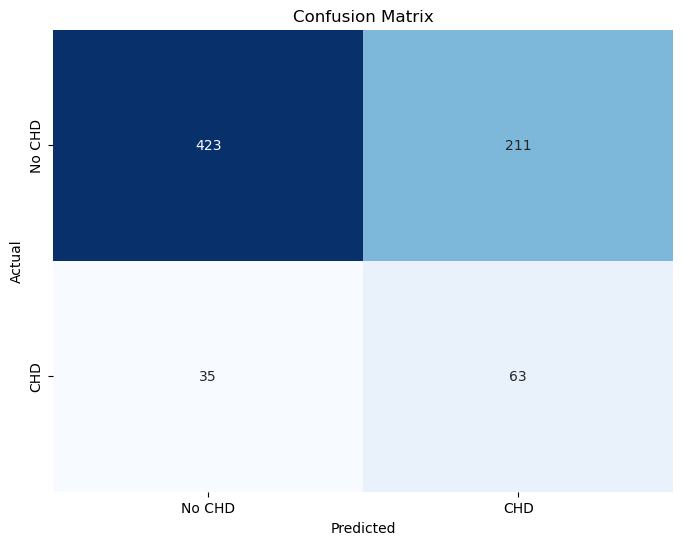

Accuracy: 0.6639344262295082

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.67      0.77       634
           1       0.23      0.64      0.34        98

    accuracy                           0.66       732
   macro avg       0.58      0.66      0.56       732
weighted avg       0.83      0.66      0.72       732



In [112]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print accuracy and other metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

*Conclusion: The model is overly predicting people as not at risk. There is a high level of false negatives and a low number of true negatives (very low recall for the 0 class), indicating the model is biased. More investigation is needed for why the model is biased. SMOTE may have improved the model, however, more investigation is needed to determine why this bias is present*

Visualize ROC Curve

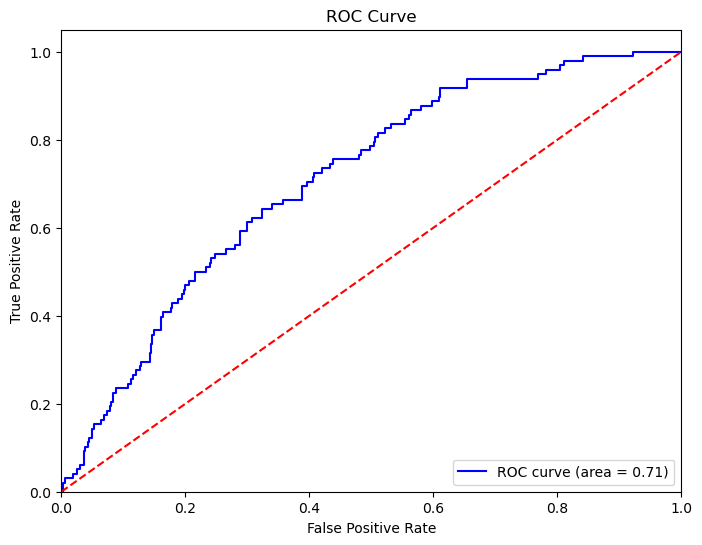

ROC AUC Score: 0.7093607158951908


In [113]:
# ROC Curve Visualization
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# See the ROC AUC score
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

*Conclusion: The model is not very good. The ROC curve is close to the 50% line, which in essence says that the model is slightly better than a coin flip. Cross-validation is needed for a deeper understanding of what is going on*

_____

**Step 6: Use Cross Validation to Help with Parameter Tuning**

In [114]:
# Create the logistic regression model
clf = LogisticRegression(random_state=42, max_iter=1000)

# Isolate the selected features for cross-validation
X_selected = X_train[selected_features]

# Cross-validation
scores = cross_val_score(clf, X_selected, y_train, cv=5, scoring='accuracy')

# Report the results
print("Cross-validated accuracies:", scores)
print("Average accuracy:", scores.mean())

Cross-validated accuracies: [0.63708087 0.67159763 0.66074951 0.6617357  0.67948718]
Average accuracy: 0.6621301775147929


Hyperparameter Tuning

In [115]:
# Grid of hyperparameters to search
param_grid = {
    'C': [0.01, 0.1, 0.5, 0.75, 1, 5, 10, 100, 1000], # regularization strength
    'penalty': ['l2'], # type of penalty
    'solver': ['liblinear'] # algorithm to use
}

# GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

Best hyperparameters: {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validated accuracy: 0.6615384615384616


Apply Parameters and Recalculate Predicted Ys

In [116]:
# Create new model with best parameters
best_model = grid_search.best_estimator_

# Get new predictions and probabilities based on new parameters
y_pred = grid_search.best_estimator_.predict(X_test)
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

Confusion Matrix

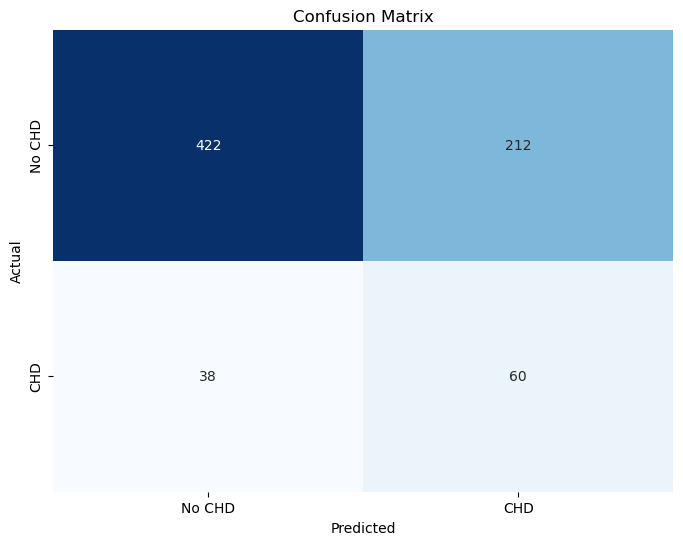

Accuracy: 0.6584699453551912

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.67      0.77       634
           1       0.22      0.61      0.32        98

    accuracy                           0.66       732
   macro avg       0.57      0.64      0.55       732
weighted avg       0.82      0.66      0.71       732



In [117]:
# Generate the confusion matrix
cm_tuned = confusion_matrix(y_test, y_pred)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print accuracy and other metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

ROC Curve

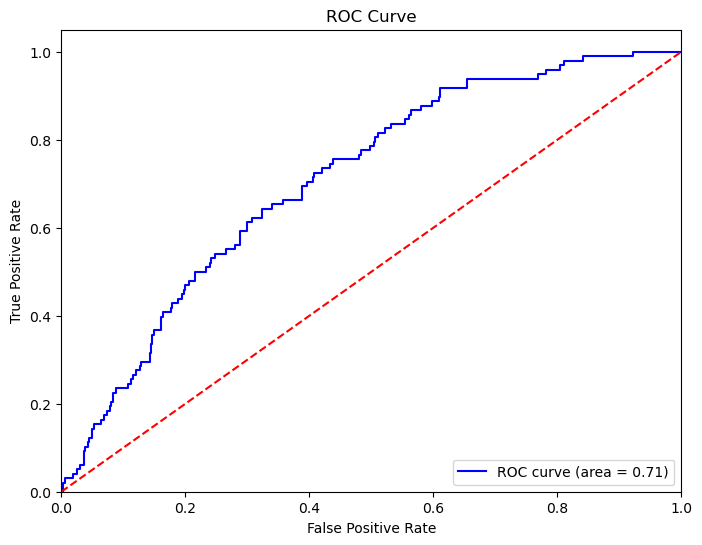

ROC AUC Score: 0.7093607158951908


In [118]:
# Create variables for the ROC curve
fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test, y_pred_prob) # y_pred_prob
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

# ROC Curve Visualization
plt.figure(figsize=(8, 6))
plt.plot(fpr_tuned, tpr_tuned, color='blue', label='ROC curve (area = %0.2f)' % roc_auc_tuned)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# See the ROC AUC score
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))